# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Loading the dataset

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Shuffling the dataset and selecting 10,000 rows

In [ ]:
# Shuffling the dataset
df = df.sample(frac=1, random_state=42)

# Selecting only 10k observations
df = df[:10000]

In [ ]:
len(df)

10000

# Data Preprocessing

## Checking for null values

In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

### There are no null values

## Initializing Stopwords using NLTK

In [ ]:
nltk.download('stopwords')
stopW = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\SAMEER
[nltk_data]     MULANI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Text Preprocessing
## The following preprocessing has been applied to the 'review' column.

1.   Lowercasing
2.   Non-word character removal
3. Digits Removal
4. Stop word removal


In [ ]:
df['review'] = df['review'].str.lower()
df['review'] = df['review'].str.replace('[^\w\s]', '')
df['review'] = df['review'].str.replace('\d', '')
df['review'] = df['review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stopW))

<ipython-input-21-413b5685acc3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('[^\w\s]', '')
<ipython-input-21-413b5685acc3>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('\d', '')


In [ ]:
df['review']

33553    really liked summerslam due look arena curtain...
9427     many television shows appeal quite many differ...
199      film quickly gets major chase scene ever incre...
12447    jane austen would definitely approve onebr br ...
39489    expectations somewhat high went see movie thou...
                               ...                        
28567    although casper van dien michael rooker genera...
25079    liked movie wasnt really sure started watching...
18707    yes nonsingaporeans cant see whats big deal fi...
15200    far films go likable enough entertaining chara...
5857     saw anatomy years ago dubbed friends house don...
Name: review, Length: 10000, dtype: object

### Finding out words which occur less than once in the entire dataset

In [ ]:
temp_df = pd.Series(' '.join(df['review']).split()).value_counts()
temp_df

br              22876
movie           16912
film            14802
one             10114
like             7837
                ...  
tibetans            1
torched             1
sturridge           1
calmalso            1
youngpeoples        1
Length: 73296, dtype: int64

In [ ]:
drops = temp_df[temp_df <= 1]

### Removing those words

In [ ]:
df['review'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

# Lemmatization

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\SAMEER
[nltk_data]     MULANI\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\SAMEER
[nltk_data]     MULANI\AppData\Roaming\nltk_data...


True

In [ ]:
df['review'] = df['review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()

,review,sentiment
33553,really liked summerslam due look arena curtain...,positive
9427,many television show appeal quite many differe...,positive
199,film quickly get major chase scene ever increa...,negative
12447,jane austen would definitely approve onebr br ...,positive
39489,expectation somewhat high went see movie thoug...,negative


## Checking for duplicate values

In [ ]:
print("The number of duplicates in training data :",df['review'].duplicated().sum())

The number of duplicates in training data : 22


In [ ]:
df.loc[df['review'].duplicated(keep=False)].sort_values("review").head()

,review,sentiment
36417,bette midler showcase talent beauty diva la ve...,positive
15384,bette midler showcase talent beauty diva la ve...,positive
15849,br br back youth old man wanted marry first co...,negative
13413,br br back youth old man wanted marry first co...,negative
36207,classed real life london producer must differe...,negative


### Dropping these duplicates

In [ ]:
print("Number of observations in training before dropping duplicates : ",df.shape[0])

Number of observations in training abefpre dropping duplicates :  10000


In [ ]:
df = df.drop_duplicates(subset="review", keep="first").reset_index(drop=True)

In [ ]:
print("Number of observations in training after dropping duplicates : ",df.shape[0])

Number of observations in training after dropping duplicates :  9978


# Exploratory Data Analysis


Extracting Term Frequencies


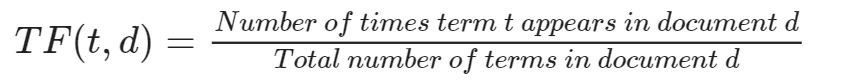

In [ ]:
tf = df["review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.head()

,index,0
0,v,135.0
1,match,239.0
2,terrible,642.0
3,luger,12.0
4,event,485.0


In [ ]:
tf.columns = ["words", "tf"]

### Top 10 most frequently occuring words

In [ ]:
tf.sort_values("tf", ascending=False)[:10]

,words,tf
90,br,22816.0
225,movie,19871.0
251,film,17987.0
23,one,10551.0
19,like,8025.0
13,time,5849.0
218,good,5824.0
89,character,5576.0
98,get,5005.0
222,even,4961.0


## It can be observed that there are certain words which contain only 1 letter

In [ ]:
def contains_one_letter(s):
    return len(s) == 1 and s.isalpha()

# Apply the function to the DataFrame column
tf['ContainsOneLetter'] = tf['words'].apply(contains_one_letter)

# Display the DataFrame
print(tf)

              words     tf  ContainsOneLetter
0                 v  135.0               True
1             match  239.0              False
2          terrible  642.0              False
3             luger   12.0              False
4             event  485.0              False
...             ...    ...                ...
32129          cini    3.0              False
32130        anansa    3.0              False
32131      suleiman    2.0              False
32132  gildersleeve    2.0              False
32133          ywca    2.0              False

[32134 rows x 3 columns]


### There are 25 such values containing only 1 letter

In [ ]:
true_rows = tf[tf['ContainsOneLetter']]
len(true_rows)

25

### Removing such words

In [ ]:
df['review'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in true_rows['words']))

## Number of characters appearing in each sentence

<AxesSubplot:>

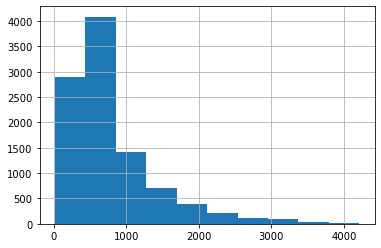

In [ ]:
df['review'].str.len().hist()

## In the above bar chart we can observe that the number of charcters in each sentence majorly ranges from 0 to 1000

# **Sentiment Analysis**

In [ ]:
df['review'].head()

0    really liked summerslam due look arena curtain...
1    many television show appeal quite many differe...
2    film quickly get major chase scene ever increa...
3    jane austen would definitely approve onebr br ...
4    expectation somewhat high went see movie thoug...
Name: review, dtype: object

# Inializing VADER SIA

Vader Sentiment Intensity Analyzer
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool specifically designed for analyzing the sentiment of text in the context of social media and informal online text. It was developed by researchers at the Georgia Institute of Technology

**The output will include scores for positivity, neutrality, and negativity, as well as a compound score that summarizes the overall sentiment of the text.**

compound score is between -1 to 1

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\SAMEER
[nltk_data]     MULANI\AppData\Roaming\nltk_data...


True

In [ ]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('The film was very awesome')

{'neg': 0.0, 'neu': 0.477, 'pos': 0.523, 'compound': 0.659}

### Dropping sentiment column

In [ ]:
df.drop(columns='sentiment',inplace=True)

In [ ]:
df["review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.129, 'neu': 0.655, 'pos': 0.216, 'co...
1    {'neg': 0.03, 'neu': 0.763, 'pos': 0.207, 'com...
2    {'neg': 0.124, 'neu': 0.674, 'pos': 0.202, 'co...
3    {'neg': 0.101, 'neu': 0.563, 'pos': 0.336, 'co...
4    {'neg': 0.155, 'neu': 0.697, 'pos': 0.148, 'co...
5    {'neg': 0.113, 'neu': 0.587, 'pos': 0.3, 'comp...
6    {'neg': 0.244, 'neu': 0.424, 'pos': 0.332, 'co...
7    {'neg': 0.116, 'neu': 0.693, 'pos': 0.191, 'co...
8    {'neg': 0.109, 'neu': 0.664, 'pos': 0.227, 'co...
9    {'neg': 0.092, 'neu': 0.669, 'pos': 0.239, 'co...
Name: review, dtype: object

In [ ]:
df["review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0    0.9020
1    0.9867
2    0.6712
3    0.9702
4   -0.1243
5    0.9975
6    0.7430
7    0.9488
8    0.9624
9    0.9801
Name: review, dtype: float64

## Creating a column called polarity_score to store the compound values

In [ ]:
df["polarity_score"] = df["review"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Feature Engineering

## Labelling sentiment scores
If compound score > 0  then it is a positive comment

If coumpound score < 0 then it is a negative comment

In [ ]:
df['polarity_score'][0:10].apply(lambda x : 'pos' if x>0 else 'neg')

0    pos
1    pos
2    pos
3    pos
4    neg
5    pos
6    pos
7    pos
8    pos
9    pos
Name: polarity_score, dtype: object

In [ ]:
df['sentiment_label'] = df['polarity_score'].apply(lambda x : 'pos' if x>0 else 'neg')
df['sentiment_label'].value_counts()

pos    6932
neg    3046
Name: sentiment_label, dtype: int64

### Visualizing classes

<AxesSubplot:xlabel='sentiment_label', ylabel='count'>

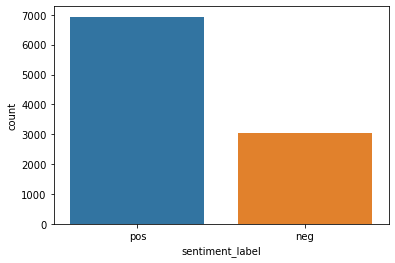

In [ ]:
import seaborn as sns
sns.countplot(x = 'sentiment_label',data = df)

## Label encoding the sentiment_label column

In [ ]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [ ]:
df.head()

,review,polarity_score,sentiment_label
0,really liked summerslam due look arena curtain...,0.9020,1
1,many television show appeal quite many differe...,0.9867,1
2,film quickly get major chase scene ever increa...,0.6712,1
3,jane austen would definitely approve onebr br ...,0.9702,1
4,expectation somewhat high went see movie thoug...,-0.1243,0


## Reviews with highest polarity score

In [ ]:
print("Review with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity_score'].sort_values(ascending=False)[:1].index]['review']):
  print('Review {}:\n'.format(index+1),review)

Review with Highest Polarity:
Review 1:
 actually great fun really enjoyed even though wasnt original robert de niro eddie murphy great together character cool story pretty good plus robert de niro eddie murphy simply amazing rene russo excellent role plenty laugh throughout especially deniro spoof clint eastwood danny glovers line plus finale great yes another run mil buddy buddy cop film work due fantastic chemistry de niro murphy plus great car chase scene well nothing great really however found great fun perfect way pas main villain weak wasnt good far best buddy buddy cop film however still entertaining one thought pretty well made written well plus ending quite funny actually great fun really enjoyed even though wasnt original de niro eddie murphy great together highly recommend one direction good tom dey good job great camera work cool angle keeping film fast pace acting lot fun robert deniro amazing always amazing hilarious likable fantastic chemistry eddie murhpy usual awesome

## Reviews with lowest polarity score

In [ ]:
print("Review with Lowest Polarity:")
for index,review in enumerate(df.iloc[df['polarity_score'].sort_values(ascending=True)[:].index]['review']):
  print('Review {}:\n'.format(index+1),review)

Review with Lowest Polarity:
Review 1:
 fire plain film excellent many level enough good thing said regret able see film soonerbr br something film purist tend look film artistic merit based upon dialog acting photography even effort remain true period term costume ultimately want know film truthful enough revealing human condition make think without oppressing director want thinkbr br fire plain great film craft portrait filled realistic human reaction dying fire great historical catastrophebr br ichikawas film condemnation war level good war film war horrifying bloody destructive also murderous psyche however fundamental fire plain unapologetic look japanese soldier show slowly collapsing weight superior american firepower nation inability wage war making fatalistic code encouraging death surrender heart madnessbr br astonished see honest brutally close look bitter fruit japan military misadventure made year end japanese call great pacific war ichikawa reveals german called war life 

## X,y

In [ ]:
y = df['sentiment_label']
X = df['review']

# **Application of TF-IDF and N-Gram**

In [ ]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

## Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf_word, y, test_size=0.3, random_state=42)

# **Sentiment Modelling**

**Order of Execution**



1.   Model Initialization
2.   Model Fitting on our training data
3. Model Cross-Validation with 5 folds
4. Testing Model Generalizability



# 1)  **MultiNomial Naive Bayes**

In [ ]:
nb_model = MultinomialNB().fit(X_train, y_train)
nb_score = cross_val_score(nb_model,
                X_train,
                y_train,
                scoring="accuracy",
                cv=5).mean()
print(nb_score)

0.6987399318638179


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

predictions = nb_model.predict(X_test)
f1_nb = f1_score(y_test,predictions)            #STORING F1 SCORE

# 2) **Logistic Regressor**

In [ ]:
lr_model = LogisticRegression().fit(X_train, y_train)
lr_score = cross_val_score(lr_model,
                X_train,
                y_train,
                scoring="accuracy",
                cv=5).mean()
print(lr_score)


0.7973939243528395


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

predictions = lr_model.predict(X_test)
f1_lr = f1_score(y_test,predictions)               #STORING F1 SCORE

# 3) **Support Vector Model**

In [ ]:
svc_model = SVC().fit(X_train, y_train)
svc_score = cross_val_score(svc_model,
                X_train,
                y_train, scoring = "accuracy",
                cv=5, n_jobs=-1).mean()
print(svc_score)

0.8016896624572099


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

predictions = svc_model.predict(X_test)
f1_svc = f1_score(y_test,predictions)             #STORING F1 SCORE

# 4) **Decision Tree Model**

In [ ]:
dc_model = DecisionTreeClassifier().fit(X_train, y_train)
dc_score = cross_val_score(dc_model,
                X_train,
                y_train, scoring = "accuracy",
                cv=5, n_jobs=-1).mean()
print(dc_score)


0.6990279005564524


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

predictions = dc_model.predict(X_test)
f1_dc = f1_score(y_test,predictions)                #STORING F1 SCORE

# 5) **Random Forest Model**

In [ ]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
rf_score = cross_val_score(rf_model,
                X_train,
                y_train, scoring = "accuracy",
                cv=5, n_jobs=-1).mean()
print(rf_score)

0.7571585037934337


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

predictions = rf_model.predict(X_test)
f1_rf = f1_score(y_test,predictions)            #STORING F1 SCORE

# Printing all Model Scores

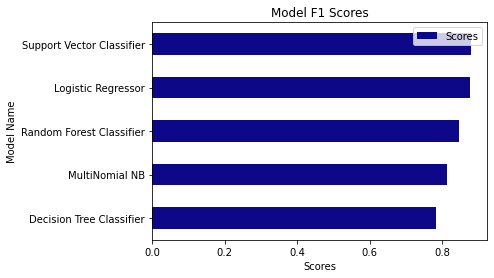

In [ ]:
scores = {
    'Model Name' : ["MultiNomial NB", "Logistic Regressor", "Support Vector Classifier", "Decision Tree Classifier", "Random Forest Classifier"],
    'Scores' : [f1_nb, f1_lr, f1_svc, f1_dc, f1_rf]
}

scores_df = pd.DataFrame(scores)
scores_df.sort_values(by='Scores',inplace=True)

scores_df.plot(x='Model Name', y='Scores', kind='barh',colormap = 'plasma')



plt.xlabel('Scores')
plt.ylabel('Model Name')
plt.title('Model F1 Scores')

plt.show()

# In the above chart we can see that Support Vector Classifier gives us the highest F1-score  

## (The above bar chart is sorted in descending order)

# Checking generalizability of the SVC model

In [ ]:
# introducing a positive review
new_review = pd.Series("This movie is amazing, highly recommended.")

#vectorizing the review
new_review = TfidfVectorizer().fit(X).transform(new_review)

# predicting the sentiment of our review
if svc_model.predict(new_review) == 1:
    print('It is a positive review')
else:
    print('It is a negative review')


It is a positive review


In [ ]:
# introducing a negative review
new_review = pd.Series("This is the worst movie I have ever watched")

# vectorizing the review
new_review = TfidfVectorizer().fit(X).transform(new_review)

# predicting the sentiment of our review
if svc_model.predict(new_review) == 1:
    print('It is a positive review')
else:
    print('It is a negative review')


It is a negative review
